## Import Libraries

In [138]:
import pandas as pd
import numpy as np
from math import sin, cos, exp, fabs, radians
from scipy.optimize import differential_evolution, least_squares, minimize_scalar
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

## Load Data

In [4]:
df = pd.read_csv('xy_data.csv')

In [5]:
df

,x,y
0,88.364456,57.784378
1,74.283936,54.406780
2,60.256474,46.311462
3,82.134370,57.717567
4,101.036390,67.849340
...,...,...
1495,99.653260,68.500260
1496,66.533380,47.578316
1497,83.447020,57.533510
1498,63.372417,47.135735


## Approach 1: Bayesian Optimization

In [ ]:
observed_coords = np.array(df)
n = observed_coords.shape[0]

In [25]:
t_lower = 6
t_upper = 60

In [26]:
def model_point(t, theta_deg, M, X):
    theta = radians(theta_deg)
    x = t * cos(theta) - np.exp(M * abs(t)) * np.sin(0.3 * t) * np.sin(theta) + X
    y = 42 + t * np.sin(theta) + np.exp(M * abs(t)) * np.sin(0.3 * t) * np.cos(theta)
    return x, y


In [94]:
import numpy as np

def model_dxy_dt(t, theta, M, X):
    """Derivative of x(t), y(t) with respect to t."""
    sign_t = np.sign(t)
    exp_term = np.exp(M * np.abs(t))
    sin_term = np.sin(0.3 * t)
    cos_term = np.cos(0.3 * t)

    dx_dt = (np.cos(theta)
             - exp_term * np.sin(theta) * (M * sign_t * sin_term + 0.3 * cos_term))
    dy_dt = (np.sin(theta)
             + exp_term * np.cos(theta) * (M * sign_t * sin_term + 0.3 * cos_term))
    return dx_dt, dy_dt


In [ ]:
# def best_t_for_point(x_obs, y_obs, theta_deg, M, X):
#     # objective in terms of t (scalar)
#     def obj_t(t):
#         xm, ym = model_point(t, theta_deg, M, X)
#         return (xm - x_obs)**2 + (ym - y_obs)**2

#     # bounded scalar minimization
#     res = minimize_scalar(obj_t, bounds=(t_lower, t_upper), method='bounded', options={'xatol':1e-8})
#     # return best t and the objective value
#     return res.x, res.fun




t_lower, t_upper = 6, 60
t_grid = np.linspace(t_lower, t_upper, 10000)

def best_t_for_point(x_obs, y_obs, theta_deg, M, X):
    """
    finds the best t for a given observed point
    """
    theta = np.deg2rad(theta_deg)

    # Coarse search using KDTree 
    xg = t_grid * np.cos(theta) - np.exp(M * np.abs(t_grid)) * np.sin(0.3 * t_grid) * np.sin(theta) + X
    yg = 42 + t_grid * np.sin(theta) + np.exp(M * np.abs(t_grid)) * np.sin(0.3 * t_grid) * np.cos(theta)
    tree = cKDTree(np.column_stack([xg, yg]))

    _, idx = tree.query([[x_obs, y_obs]])
    t_guess = t_grid[idx[0]]

    # Newton's root finding algorthm
    t = t_guess
    for _ in range(5):
        # compute model values and first derivatives
        x_t = t * np.cos(theta) - np.exp(M * abs(t)) * np.sin(0.3 * t) * np.sin(theta) + X
        y_t = 42 + t * np.sin(theta) + np.exp(M * abs(t)) * np.sin(0.3 * t) * np.cos(theta)

        sign_t = np.sign(t)
        exp_term = np.exp(M * abs(t))
        sin_term = np.sin(0.3 * t)
        cos_term = np.cos(0.3 * t)
        dx_dt = (np.cos(theta)
                 - exp_term * np.sin(theta) * (M * sign_t * sin_term + 0.3 * cos_term))
        dy_dt = (np.sin(theta)
                 + exp_term * np.cos(theta) * (M * sign_t * sin_term + 0.3 * cos_term))

        # derivative and second derivative 
        f_prime = 2 * ((x_t - x_obs) * dx_dt + (y_t - y_obs) * dy_dt)
        eps = 1e-5
        dx1, dy1 = model_dxy_dt(t + eps, theta, M, X)
        dx2, dy2 = model_dxy_dt(t - eps, theta, M, X)
        d2x = (dx1 - dx2) / (2 * eps)
        d2y = (dy1 - dy2) / (2 * eps)
        f_double_prime = 2 * (dx_dt ** 2 + dy_dt ** 2 +
                              (x_t - x_obs) * d2x + (y_t - y_obs) * d2y)

        step = f_prime / f_double_prime if f_double_prime != 0 else 0
        t -= step
        t = np.clip(t, t_lower, t_upper)

    # final objective value
    xm, ym = (t * np.cos(theta) - np.exp(M * abs(t)) * np.sin(0.3 * t) * np.sin(theta) + X,
              42 + t * np.sin(theta) + np.exp(M * abs(t)) * np.sin(0.3 * t) * np.cos(theta))
    obj_val = (xm - x_obs) ** 2 + (ym - y_obs) ** 2

    return t, obj_val


In [ ]:
def rss_for_params(theta_deg, M, X, verbose=False):
    """
    computes residual sum of squares(RSS) for given params
    """
    rss = 0.0
    t_values = []
    for (x_obs, y_obs) in observed_coords:
        t_opt, val = best_t_for_point(x_obs, y_obs, theta_deg, M, X)
        rss += val
        t_values.append(t_opt)
    if verbose:
        return rss, np.array(t_values)
    return rss

In [ ]:
def objective(theta, M, X):
    # objective function
    theta = float(theta)
    M = float(M)
    X = float(X)
    rss = rss_for_params(theta, M, X)
    # return negative RSS to minimize RSS(maximize -RSS)
    return -rss

In [ ]:
pbounds = {
    # parameter bounds
    'theta': (0, 50),
    'M': (-0.05, 0.05),
    'X': (0.0, 100.0)
}

In [ ]:
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2,
)

In [95]:
optimizer.maximize(init_points=40, n_iter=460)

|   iter    |  target   |   theta   |     M     |     X     |
-------------------------------------------------------------
| 1         | -964781.1 | 29.932924 | -0.034398 | 15.599452 |
| 2         | -310032.3 | 2.9041806 | 0.0366176 | 60.111501 |
| 3         | -1013707. | 35.403628 | -0.047941 | 96.990985 |
| 4         | -1656892. | 41.622132 | -0.028766 | 18.182496 |
| 5         | -228455.0 | 9.1702254 | -0.019575 | 52.475643 |
| 6         | -84360.01 | 21.597250 | -0.020877 | 61.185289 |
| 7         | -252857.1 | 6.9746930 | -0.020785 | 36.636184 |
| 8         | -376561.9 | 22.803499 | 0.0285175 | 19.967378 |
| 9         | -1368242. | 25.711721 | 0.0092414 | 4.6450412 |
| 10        | -1615383. | 30.377242 | -0.032947 | 6.5051592 |
| 11        | -188219.0 | 47.444276 | 0.0465632 | 80.839734 |
| 12        | -247729.3 | 15.230688 | -0.040232 | 68.423302 |
| 13        | -21698.54 | 22.007624 | -0.037796 | 49.517691 |
| 14        | -566346.9 | 1.7194260 | 0.0409320 | 25.877998 |
| 15    

In [101]:
optimizer.maximize(init_points=0, n_iter=500)

|   iter    |  target   |   theta   |     M     |     X     |
-------------------------------------------------------------
| 540       | -55474.55 | 11.981477 | 0.05      | 51.202944 |
| 541       | -4912.773 | 30.483025 | 0.05      | 54.480081 |
| 542       | -6011.653 | 27.857826 | 0.05      | 57.134913 |
| 543       | -28687.36 | 22.741017 | -0.05     | 42.167771 |
| 544       | -10698.59 | 31.004681 | 0.05      | 52.008161 |
| 545       | -9840.323 | 38.348228 | 0.05      | 55.954855 |
| 546       | -25786.08 | 34.497383 | 0.05      | 64.624647 |
| 547       | -53180.91 | 46.336504 | 0.05      | 71.255758 |
| 548       | -5732.563 | 31.304691 | 0.05      | 53.969095 |
| 549       | -8501.972 | 36.993505 | 0.05      | 55.134827 |
| 550       | -3709.499 | 32.570181 | 0.05      | 56.470894 |
| 551       | -4441.287 | 29.154008 | 0.05      | 55.436623 |
| 552       | -16486.97 | 40.088891 | 0.05      | 54.825058 |
| 553       | -17587.23 | 36.749586 | 0.05      | 51.375125 |
| 554   

In [165]:
best = optimizer.max
best_params = best['params']
best_theta = best_params['theta']
best_M = best_params['M']
best_X = best_params['X']
best_rss = -best['target']

In [166]:
best_theta, best_M, best_X #best parameters using Bayesian Optimization

(np.float64(31.753118052470086),
 np.float64(0.05),
 np.float64(56.418148158662966))

In [167]:
rss_val, t_vals = rss_for_params(best_theta, best_M, best_X, verbose=True)
print("\nBest-fit t values (one per observed point):")
for i, t in enumerate(t_vals[:10], 1):
    print(f"  point {i}: t = {t:.8f}")


Best-fit t values (one per observed point):
  point 1: t = 34.33540857
  point 2: t = 21.95160005
  point 3: t = 6.00000000
  point 4: t = 31.06323379
  point 5: t = 52.65655609
  point 6: t = 14.13468274
  point 7: t = 25.98083613
  point 8: t = 41.54430851
  point 9: t = 54.02489388
  point 10: t = 24.32281787


In [168]:
# fitted (x,y) for those t and residuals
fitted = np.array([model_point(t, best_theta, best_M, best_X) for t in t_vals])
residuals = fitted - observed_coords
print("\nResiduals (x_pred-x_obs, y_pred-y_obs) per point:")
for i, r in enumerate(residuals[:10], 1):
    print(f"  point {i}: dx = {r[0]:+.6e}, dy = {r[1]:+.6e}")


Residuals (x_pred-x_obs, y_pred-y_obs) per point:
  point 1: dx = -5.000431e-01, dy = -1.350628e+00
  point 2: dx = +3.306390e-01, dy = -9.585646e-02
  point 3: dx = +5.718168e-01, dy = -3.610215e-02
  point 4: dx = +4.348924e-01, dy = +1.054221e+00
  point 5: dx = +8.076839e-01, dy = +8.101337e-01
  point 6: dx = +1.033384e-01, dy = -5.029977e-01
  point 7: dx = -1.225579e+00, dy = +1.195389e+00
  point 8: dx = +8.796093e-01, dy = +1.333659e-01
  point 9: dx = -1.556157e+00, dy = -1.550922e+00
  point 10: dx = -8.136219e-01, dy = +3.638302e-01


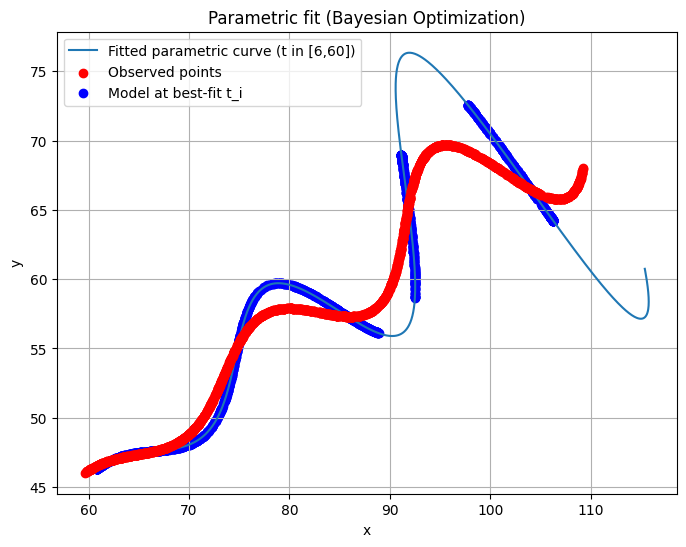

In [159]:
ts = np.linspace(t_lower, t_upper, 1000)
curve = np.array([model_point(t, best_theta, best_M, best_X) for t in ts])

plt.figure(figsize=(8,6))
plt.plot(curve[:,0], curve[:,1], label='Fitted parametric curve (t in [6,60])')
plt.scatter(observed_coords[:,0], observed_coords[:,1], color='red', zorder=5, label='Observed points')
plt.scatter(fitted[:,0], fitted[:,1], color='blue', marker='o', label='Model at best-fit t_i')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Parametric fit (Bayesian Optimization)')
plt.grid(True)
plt.show()

## Approach 2: Differential Evolution(better fit)

In [125]:
x_obs = np.array(observed_coords[:,0])
y_obs = np.array(observed_coords[:,1])

In [126]:
def model_xy(t, theta_rad, M, X):
    #theta is in radians
    t = np.asarray(t)

    x = t * np.cos(theta_rad) - np.exp(M * np.abs(t)) * np.sin(0.3 * t) * np.sin(theta_rad) + X
    y = 42 + t * np.sin(theta_rad) + np.exp(M * np.abs(t)) * np.sin(0.3 * t) * np.cos(theta_rad)
    return x, y


In [127]:

def model_dxy_dt(t, theta_rad, M, X):
    """Compute dx/dt and dy/dt."""
    t = np.asarray(t)
    sign_t = np.sign(t)
    E = np.exp(M * np.abs(t))
    S = np.sin(0.3 * t)
    C = np.cos(0.3 * t)
    ct = np.cos(theta_rad)
    st = np.sin(theta_rad)
    # derivative of (E*S)
    dES_dt = E * (M * sign_t * S + 0.3 * C)
    dx_dt = ct - dES_dt * st
    dy_dt = st + dES_dt * ct
    return dx_dt, dy_dt

In [ ]:
def coarse_projection_all(x_obs, y_obs, theta_rad, M, X, t_min=6.0, t_max=60.0, n_grid=10000):

    """
    returns the closest t values corresponding to each observed (x,y) point
    returns the shortest distance between observed points and model points
    returns the full grid of t values and all model curve points corrsponding to those t values
    """

    t_grid = np.linspace(t_min, t_max, n_grid)
    xg, yg = model_xy(t_grid, theta_rad, M, X)
    tree = cKDTree(np.column_stack([xg, yg]))
    dists, idx = tree.query(np.column_stack([x_obs, y_obs]), k=1)
    return t_grid[idx], dists, t_grid, (xg, yg)

In [129]:
def newton_refine_all(x_obs, y_obs, theta_rad, M, X, t_init, n_iter=6):

    """
    refines initial t estimates using Newton's method to minimize distances between observed points and model curve
    to give better accuracy
    """
    t = t_init.astype(float).copy()
    eps = 1e-6
    for _ in range(n_iter):
        x_t, y_t = model_xy(t, theta_rad, M, X)
        dx_dt, dy_dt = model_dxy_dt(t, theta_rad, M, X)

        fprime = 2.0 * ((x_t - x_obs) * dx_dt + (y_t - y_obs) * dy_dt)

        dx1, dy1 = model_dxy_dt(t + eps, theta_rad, M, X)
        dx2, dy2 = model_dxy_dt(t - eps, theta_rad, M, X)
        d2x = (dx1 - dx2) / (2 * eps)
        d2y = (dy1 - dy2) / (2 * eps)

        f2 = 2.0 * (dx_dt**2 + dy_dt**2 + (x_t - x_obs) * d2x + (y_t - y_obs) * d2y)

        denom = np.where(np.abs(f2) < 1e-12, np.sign(f2) * 1e-12, f2)
        step = fprime / denom
        step = np.clip(step, -2.0, 2.0)
        t -= step
        t = np.clip(t, 6.0, 60.0)
    return t

In [130]:
def project_all_points(x_obs, y_obs, theta_deg, M, X, n_grid=10000, n_iter_newton=6):

    """
    returns the residual sum of squares (rss) and the refined t values for all observations.
    """
    theta_rad = np.deg2rad(theta_deg)
    t_guess, coarse_dists, t_grid, _ = coarse_projection_all(x_obs, y_obs, theta_rad, M, X, n_grid=n_grid)
    t_refined = newton_refine_all(x_obs, y_obs, theta_rad, M, X, t_guess, n_iter=n_iter_newton)
    x_fit, y_fit = model_xy(t_refined, theta_rad, M, X)
    rss = np.sum((x_fit - x_obs)**2 + (y_fit - y_obs)**2)
    return rss, t_refined

In [131]:
def rss_obj_de(params):

    # objective function for differential evolution
    theta_deg, M, X = params
    rss, _ = project_all_points(x_obs, y_obs, theta_deg, M, X, n_grid=8000, n_iter_newton=5)
    return rss


bounds = [
    (0.0, 50.0),    # theta
    (-0.05, 0.05),  # M
    (0.0, 100.0)    # X
]

In [ ]:
result = differential_evolution(rss_obj_de, bounds, popsize=12, maxiter=60, tol=1e-6, seed=42, disp=True)

#best params(theta, M, X)
print(f"RSS = {result.fun:.6f}")
best_theta_deg, best_M, best_X = result.x
print(f"Best parameters: θ(deg)={best_theta_deg:.6f}, M={best_M:.6f}, X={best_X:.6f}")

differential_evolution step 1: f(x)= 1830.6957067631263
differential_evolution step 2: f(x)= 1830.6957067631263
differential_evolution step 3: f(x)= 1830.6957067631263
differential_evolution step 4: f(x)= 1830.6957067631263
differential_evolution step 5: f(x)= 1830.6957067631263
differential_evolution step 6: f(x)= 1830.6957067631263
differential_evolution step 7: f(x)= 901.7120738299952
differential_evolution step 8: f(x)= 104.21598650513303
differential_evolution step 9: f(x)= 104.21598650513303
differential_evolution step 10: f(x)= 63.58881492968287
differential_evolution step 11: f(x)= 63.58881492968287
differential_evolution step 12: f(x)= 27.407979382386003
differential_evolution step 13: f(x)= 27.407979382386003
differential_evolution step 14: f(x)= 22.466078846327335
differential_evolution step 15: f(x)= 11.042454249176636
differential_evolution step 16: f(x)= 11.042454249176636
differential_evolution step 17: f(x)= 11.042454249176636
differential_evolution step 18: f(x)= 3.716

In [162]:
np.deg2rad(29.999973)

np.float64(0.5235983043594008)

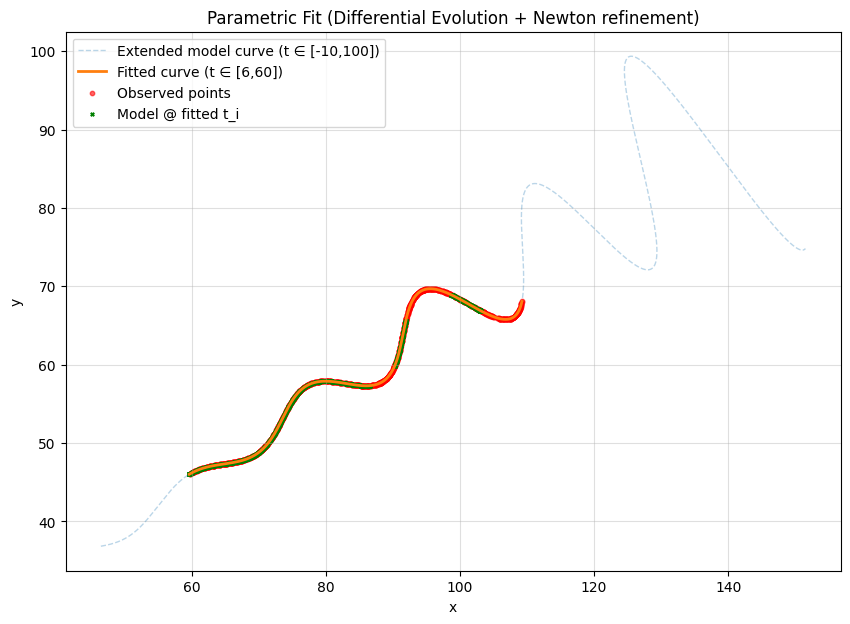

In [148]:
x1, y1 = model_xy(np.linspace(-10, 100, 3000), np.deg2rad(best_theta_deg), best_M, best_X) 
x_curve, y_curve = model_xy(np.linspace(6, 60, 3000), np.deg2rad(best_theta_deg), best_M, best_X)
x_fit, y_fit = model_xy(t_vals, np.deg2rad(best_theta_deg), best_M, best_X)


plt.figure(figsize=(10,7))
plt.plot()
plt.plot(x1, y1, '--', lw=1, alpha=0.3, label='Extended model curve (t ∈ [-10,100])')
plt.plot(x_curve, y_curve, '-', lw=2, label='Fitted curve (t ∈ [6,60])')
plt.scatter(x_obs, y_obs, s=10, c='red', label='Observed points', alpha=0.6)
plt.scatter(x_fit, y_fit, s=6, c='green', marker='x', label='Model @ fitted t_i')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Parametric Fit (Differential Evolution + Newton refinement)')
plt.grid(alpha=0.4)
plt.legend()
plt.show()